# Image Classification

The objective of this project is to classify images from the  [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).The dataset consists of airplanes, dogs, cats, and other objects.


In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck



Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 4:
Image - Min Value: 10 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


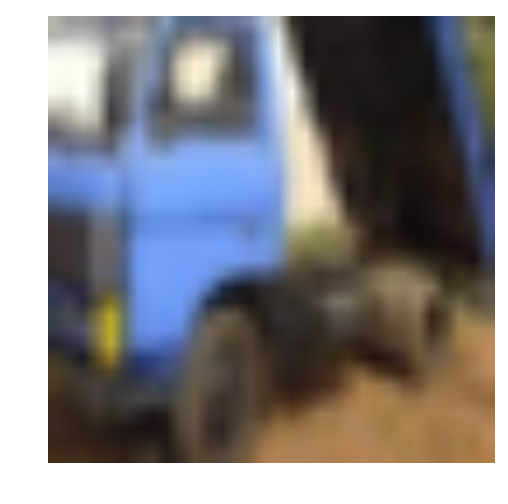

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 4
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below,the `normalize` function takes in image data, `x`, and return it as a normalized Numpy array. 

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x/255

tests.test_normalize(normalize)

Tests Passed


### One-hot encode

In [4]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    enc = OneHotEncoder(n_values=10)
    one_hot_encoded_labels = enc.fit_transform(np.array(x).reshape(-1, 1)).toarray()
    return one_hot_encoded_labels

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


# Check Point


In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network


### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape = ((None, )+  image_shape), name = 'x')

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape = (None ,n_classes), name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name = 'keep_prob')


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer


In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights_shape = list(conv_ksize) + [x_tensor.get_shape().as_list()[3], conv_num_outputs]
    mu = 0
    sigma = 0.1 
    conv_W = tf.Variable(tf.truncated_normal(shape= weights_shape, mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(conv_num_outputs))
    conv = tf.nn.conv2d(x_tensor, conv_W , strides= [1,conv_strides[0], conv_strides[1], 1], padding= 'SAME') + conv_b
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize = [1,pool_ksize[0], pool_ksize[1], 1], strides = [1, pool_strides[0], pool_strides[1], 1],padding = 'VALID')
    return conv



tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer


In [9]:
from tensorflow.contrib.layers import flatten
def flatten_tensor(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """  
    return flatten(x_tensor)


tests.test_flatten(flatten_tensor)

Tests Passed


### Fully-Connected Layer


In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc1_W = tf.Variable(tf.truncated_normal(shape=(x_tensor.get_shape().as_list()[1],num_outputs), mean = 0, stddev = 0.1))
    fc1_b = tf.Variable(tf.zeros(num_outputs))
    fc1   = tf.matmul(x_tensor, fc1_W) + fc1_b   
    fc1   = tf.nn.relu(fc1) 
    return fc1


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer


In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    flattened_shape = np.array(x_tensor.get_shape().as_list()[1:]).prod()
    # Define trainable variables.
    weights = tf.Variable(tf.truncated_normal([flattened_shape, num_outputs], mean = 0, stddev = 0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    
    # Output layer.    
    return tf.add(tf.matmul(x_tensor, weights), bias)



tests.test_output(output)

Tests Passed


### Create Convolutional Model
 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """

    layer1 = conv2d_maxpool(x, conv_num_outputs = 64 ,
                                conv_ksize = [5,5] , 
                                conv_strides = [1,1], 
                                pool_ksize = [3,3], 
                                pool_strides = [2,2])
    
    conv = conv2d_maxpool(layer1, conv_num_outputs = 64, 
                                conv_ksize = [5,5],
                                conv_strides = [1,1],
                                pool_ksize = [3,3],
                                pool_strides = [2,2])
    


    flattened_input = flatten(conv)


    fc1  = fully_conn(flattened_input, 400)
    fc2  = fully_conn(fc1, 120)
    
    fc = tf.nn.dropout(fc2, keep_prob)
    

    return output(fc,10)



##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization


In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
                                     x : feature_batch,
                                     y : label_batch, 
                                     keep_prob: keep_probability
        } )


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats


In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={
                                         x: feature_batch,
                                         y: label_batch, 
                                         keep_prob : 1.0
                                        })
    valid_acc = session.run(accuracy, feed_dict ={
                                                  x:feature_batch, 
                                                  y: label_batch, 
                                                  keep_prob:1.0
                                                 })
    print("Loss{:>10.4f}",loss)
    print("Validation Accuracy{:0.6f}",valid_acc)

### Hyperparameters


In [15]:
epochs = 10
batch_size = 128
keep_probability = 0.6

### Train on a Single CIFAR-10 Batch


In [16]:

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss{:>10.4f} 1.99834
Validation Accuracy{:0.6f} 0.325
Epoch  2, CIFAR-10 Batch 1:  Loss{:>10.4f} 1.64303
Validation Accuracy{:0.6f} 0.475
Epoch  3, CIFAR-10 Batch 1:  Loss{:>10.4f} 1.49681
Validation Accuracy{:0.6f} 0.525
Epoch  4, CIFAR-10 Batch 1:  Loss{:>10.4f} 1.23413
Validation Accuracy{:0.6f} 0.625
Epoch  5, CIFAR-10 Batch 1:  Loss{:>10.4f} 1.06839
Validation Accuracy{:0.6f} 0.7
Epoch  6, CIFAR-10 Batch 1:  Loss{:>10.4f} 0.941756
Validation Accuracy{:0.6f} 0.7
Epoch  7, CIFAR-10 Batch 1:  Loss{:>10.4f} 0.830575
Validation Accuracy{:0.6f} 0.75
Epoch  8, CIFAR-10 Batch 1:  Loss{:>10.4f} 0.731054
Validation Accuracy{:0.6f} 0.775
Epoch  9, CIFAR-10 Batch 1:  Loss{:>10.4f} 0.67898
Validation Accuracy{:0.6f} 0.775
Epoch 10, CIFAR-10 Batch 1:  Loss{:>10.4f} 0.524722
Validation Accuracy{:0.6f} 0.825


### Fully Train the Model


In [17]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss{:>10.4f} 2.01189
Validation Accuracy{:0.6f} 0.275
Epoch  1, CIFAR-10 Batch 2:  Loss{:>10.4f} 1.50124
Validation Accuracy{:0.6f} 0.4
Epoch  1, CIFAR-10 Batch 3:  Loss{:>10.4f} 1.34965
Validation Accuracy{:0.6f} 0.5
Epoch  1, CIFAR-10 Batch 4:  Loss{:>10.4f} 1.3496
Validation Accuracy{:0.6f} 0.5
Epoch  1, CIFAR-10 Batch 5:  Loss{:>10.4f} 1.31678
Validation Accuracy{:0.6f} 0.5
Epoch  2, CIFAR-10 Batch 1:  Loss{:>10.4f} 1.38855
Validation Accuracy{:0.6f} 0.55
Epoch  2, CIFAR-10 Batch 2:  Loss{:>10.4f} 1.0758
Validation Accuracy{:0.6f} 0.6
Epoch  2, CIFAR-10 Batch 3:  Loss{:>10.4f} 0.955695
Validation Accuracy{:0.6f} 0.675
Epoch  2, CIFAR-10 Batch 4:  Loss{:>10.4f} 1.07048
Validation Accuracy{:0.6f} 0.575
Epoch  2, CIFAR-10 Batch 5:  Loss{:>10.4f} 0.974788
Validation Accuracy{:0.6f} 0.675
Epoch  3, CIFAR-10 Batch 1:  Loss{:>10.4f} 0.982865
Validation Accuracy{:0.6f} 0.725
Epoch  3, CIFAR-10 Batch 2:  Loss{:>10.4f} 0.756614
Validation Accuracy{:0

# Checkpoint
The model has been saved to disk.
## Test Model


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6875988924050633



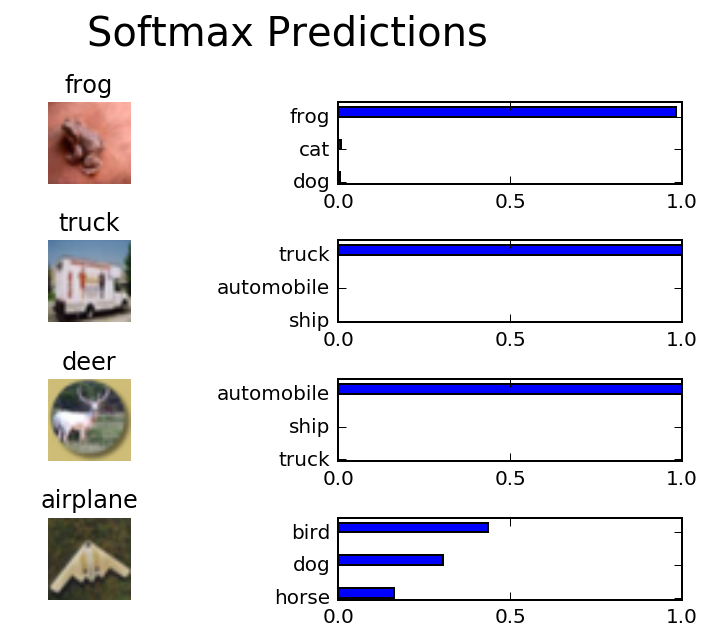

In [18]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()